In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50 ,InceptionV3, Xception, DenseNet121, DenseNet169
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import json
import math
import os
import cv2
from PIL import Image
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
from keras import regularizers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
%matplotlib inline
import seaborn as sns
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

2024-03-17 06:26:04.072790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 06:26:04.072881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 06:26:04.206975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read the data
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [3]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [5]:
train_df.shape

(3662, 2)

In [6]:
train_df['diagnosis'].value_counts()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64

In [7]:
test_df.shape

(1928, 1)

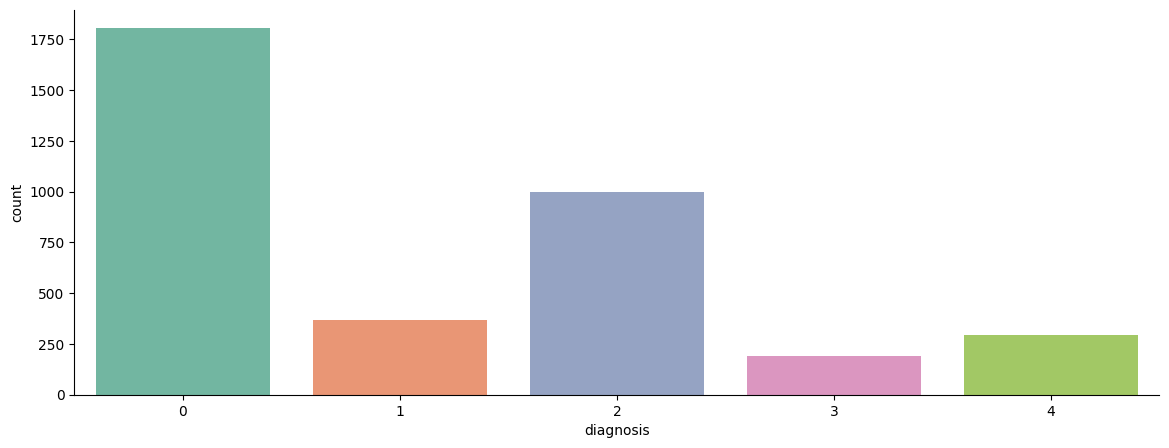

In [8]:
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train_df, palette="Set2")
sns.despine()
plt.show()

**Upsampling**

In [9]:
# Upsampling
from sklearn.utils import resample

upsampled_data = pd.DataFrame(columns=train_df.columns)  

upsampled_data = pd.DataFrame(columns=train_df.columns)  

class_0_count = len(train_df[train_df['diagnosis'] == 0])
for class_label in train_df['diagnosis'].unique():
    class_data = train_df[train_df['diagnosis'] == class_label]
    if class_label == 0:
        upsampled_data = pd.concat([upsampled_data, class_data])
    else:
        upsampled_class_data = resample(class_data, replace=True, n_samples=class_0_count, random_state=42)
        upsampled_data = pd.concat([upsampled_data, upsampled_class_data])

print(upsampled_data['diagnosis'].value_counts())

diagnosis
2    1805
4    1805
1    1805
0    1805
3    1805
Name: count, dtype: int64


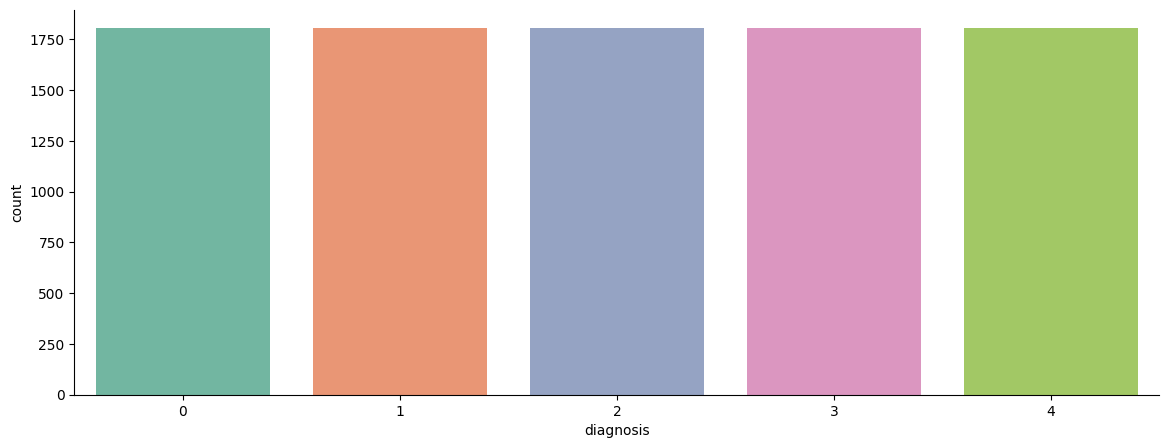

In [10]:
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=upsampled_data, palette="Set2")
sns.despine()
plt.show()

In [11]:
upsampled_data['diagnosis'].value_counts()

diagnosis
2    1805
4    1805
1    1805
0    1805
3    1805
Name: count, dtype: int64

In [12]:
upsampled_data.head()

,id_code,diagnosis
359,1a369baf9ee6,2
1498,69591ebb198d,2
3118,d88806d9ece9,2
916,4289af3afbd2,2
375,1b8ad0afe9fb,2


**Preprocessing**

In [13]:
# Function to preprocess an image
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, ) * 2, resample=Image.LANCZOS)
    im_array = np.array(im)
    return im_array

In [14]:
# Function to load and preprocess an image from its ID
def load_and_preprocess_image(image_id, folder='train_images', size=224):
    image_path = f'/kaggle/input/aptos2019-blindness-detection/{folder}/{image_id}.png'
    return preprocess_image(image_path, desired_size=size)

In [15]:
# Preprocess and split upsampled data
x_upsampled = np.array([load_and_preprocess_image(image_id, folder='train_images') for image_id in tqdm(upsampled_data['id_code'])])
y_upsampled = pd.get_dummies(upsampled_data['diagnosis']).values

100%|██████████| 9025/9025 [26:58<00:00,  5.58it/s]


In [16]:
x_upsampled.shape

(9025, 224, 224, 3)

In [17]:
y_upsampled.shape

(9025, 5)

In [18]:
y_train_multi = np.empty(y_upsampled.shape, dtype=y_upsampled.dtype)
y_train_multi[:, 4] = y_upsampled[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_upsampled[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_upsampled.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805 1805 1805 1805 1805]
Multilabel version: [9025 7220 5415 3610 1805]


In [19]:
x_train_up, x_val_up, y_train_up, y_val_up = train_test_split(x_upsampled, y_train_multi, test_size=0.2, random_state=42)

**Model Building**

In [20]:
# Create base model
def create_base_model(pre_trained_model, weights='imagenet', include_top=False):
    model = pre_trained_model(weights=weights, include_top=include_top, input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False  # Freeze pre-trained model layers
    return model

In [21]:
def add_top_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) 
    predictions = Dense(5, activation='sigmoid')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# **1. Resnet50**

In [22]:
resnet50_base = create_base_model(ResNet50)
resnet50_upsampled_model = add_top_model(resnet50_base)
resnet50_upsampled_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Ensure y_train_up and y_val_up are one-hot encoded
resnet50_model = resnet50_upsampled_model.fit(x_train_up, y_train_up, epochs=30, batch_size=32, validation_data=(x_val_up, y_val_up))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
  3/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.0417 - loss: 0.9436 

I0000 00:00:1710658416.340763     123 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.7859 - loss: 0.4608 - val_accuracy: 0.8947 - val_loss: 0.2616
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8315 - loss: 0.2739 - val_accuracy: 0.9147 - val_loss: 0.2322
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8291 - loss: 0.2373 - val_accuracy: 0.9640 - val_loss: 0.2126
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8488 - loss: 0.2173 - val_accuracy: 0.9374 - val_loss: 0.1957
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.8548 - loss: 0.2004 - val_accuracy: 0.9889 - val_loss: 0.1852
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.8760 - loss: 0.1866 - val_accuracy: 0.9751 - val_loss: 0.1754
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.8937 - loss: 0.1804 - val_accuracy: 0.9352 - val_loss: 0.1725
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8660 - loss: 0.1710 - val_accura

In [182]:
# Calculate and print accuracy for training, validation, and test sets
train_accuracy_renset50 = resnet50_upsampled_model.evaluate(x_train_up, y_train_up)[1]
val_accuracy_resnet50 = resnet50_upsampled_model.evaluate(x_val_up, y_val_up)[1]
train_loss_resnet50 = resnet50_upsampled_model.evaluate(x_train_up, y_train_up)[0]
val_loss_resnet50 = resnet50_upsampled_model.evaluate(x_val_up, y_val_up)[0]

print("ResNet50 Model Accuracy:")
print(f"Training Accuracy: {train_accuracy_renset50}")
print(f"Validation Accuracy: {val_accuracy_resnet50}")


print("ResNet50 Model Loss:")
print("Training Loss (ResNet50):", train_loss_resnet50)
print("Validation Loss (ResNet50):", val_loss_resnet50)


226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9980 - loss: 0.0476
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9968 - loss: 0.0633
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9980 - loss: 0.0476
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9968 - loss: 0.0633
ResNet50 Model Accuracy:
Training Accuracy: 0.9970914125442505
Validation Accuracy: 0.9972299337387085
ResNet50 Model Loss:
Training Loss (ResNet50): 0.04865346476435661
Validation Loss (ResNet50): 0.06697050482034683


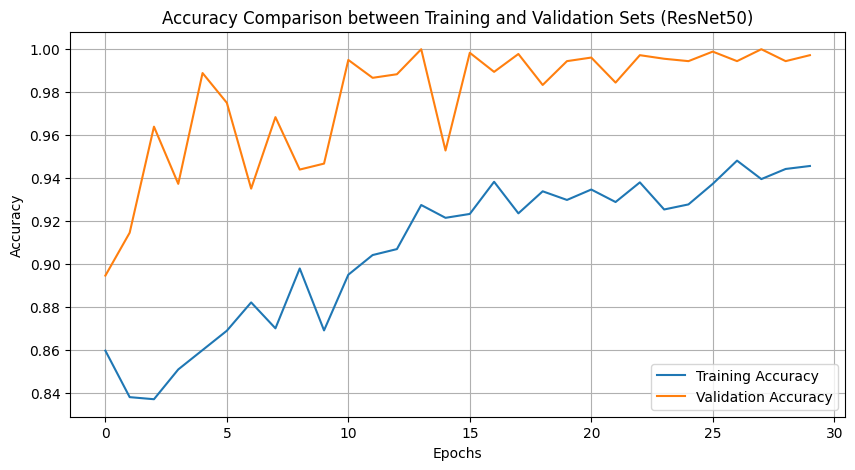

In [24]:
# Plotting Accuracy for ResNet50
plt.figure(figsize=(10, 5))
plt.plot(resnet50_model.history['accuracy'], label='Training Accuracy')
plt.plot(resnet50_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Comparison between Training and Validation Sets (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

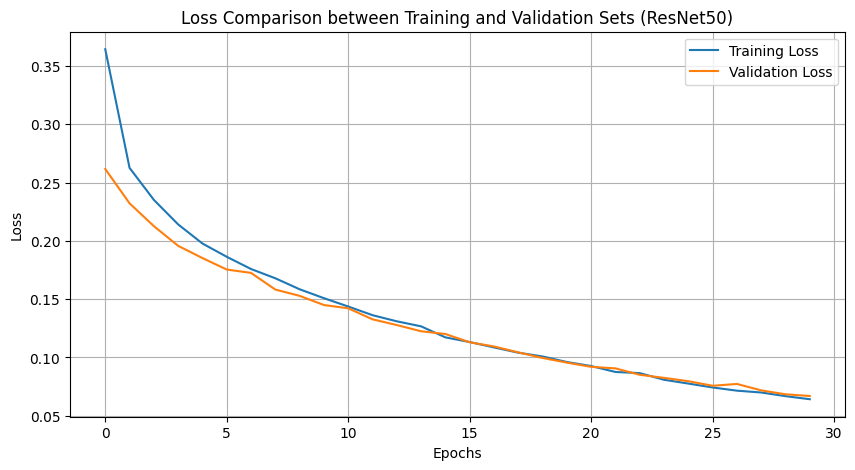

In [25]:
# Plotting Loss for ResNet50
plt.figure(figsize=(10, 5))
plt.plot(resnet50_model.history['loss'], label='Training Loss')
plt.plot(resnet50_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Comparison between Training and Validation Sets (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_val_pred_renset50 = resnet50_upsampled_model.predict(x_val_up)
y_best_renset50 = y_val_pred_renset50 > 0.37757874193797547


y_best_renset50  = y_best_renset50 .astype(int).sum(axis=1) - 1

y_true = y_val_up.sum(axis=1) - 1


print('Confusion Matrix')
print(confusion_matrix(y_best_renset50, y_true))

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step
Confusion Matrix
[[358   4   5   0   0]
 [  8 345  16   0   0]
 [  2  25 286   0   3]
 [  1   4  59 329  14]
 [  0   0  15  18 313]]


In [27]:
from sklearn.metrics import classification_report, precision_score, recall_score 
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best_renset50, y_true, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       No DR       0.97      0.98      0.97       367
        Mild       0.91      0.93      0.92       369
    Moderate       0.75      0.91      0.82       316
      Severe       0.95      0.81      0.87       407
Poliferative       0.95      0.90      0.93       346

    accuracy                           0.90      1805
   macro avg       0.91      0.91      0.90      1805
weighted avg       0.91      0.90      0.90      1805



In [28]:
cm = confusion_matrix(y_best_renset50, y_true)

sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

precision = precision_score(y_true, y_best_renset50, average=None)

recall = recall_score(y_true, y_best_renset50, average=None)


print("Sensitivity (True Positive Rate or Recall):", sensitivity)
print("\nSpecificity:", specificity)
print("\nPrecision for each class:",precision)
print("\nRecall for each class:", recall)

Sensitivity (True Positive Rate or Recall): 0.9773371104815864

Specificity: 0.988950276243094

Precision for each class: [0.97547684 0.93495935 0.90506329 0.80835381 0.90462428]

Recall for each class: [0.9701897  0.91269841 0.75065617 0.9481268  0.94848485]


In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(y_true, y_best_renset50, average='micro')

recall = recall_score(y_true, y_best_renset50, average='micro')

print("\nPrecision for each class:")
print(precision)
print("\nRecall for each class:")
print(recall)


Precision for each class:
0.903601108033241

Recall for each class:
0.903601108033241


In [30]:
misclassified=np.where(y_best_renset50!=y_true)
misclassified

print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_true[15],y_best_renset50[15])

Total Misclassified Samples:  174
3 3


In [31]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa score
kappa_score = cohen_kappa_score(y_true, y_best_renset50)

# Print the Kappa score
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.8795427479993787


In [32]:
y_test_renset50 = resnet50_upsampled_model.predict(x_val_up)
y_test_renset50

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


array([[9.9991202e-01, 9.8985755e-01, 3.2435244e-01, 2.4953902e-02,
        2.2215758e-02],
       [1.0000000e+00, 9.9999988e-01, 9.9997211e-01, 9.9935275e-01,
        3.4504686e-02],
       [9.9998534e-01, 7.1223726e-04, 1.7554342e-04, 2.6417081e-05,
        1.6348602e-05],
       ...,
       [9.9999237e-01, 9.9998498e-01, 9.9979150e-01, 9.9756783e-01,
        6.8484269e-02],
       [9.9998963e-01, 9.9989879e-01, 9.9683988e-01, 7.8316855e-01,
        8.5870147e-02],
       [9.9999940e-01, 9.9988925e-01, 9.9800509e-01, 1.3168746e-01,
        2.9154481e-02]], dtype=float32)

In [33]:
y_test_renset50 = y_test_renset50 > 0.37757874193797547
y_test_renset50

array([[ True,  True, False, False, False],
       [ True,  True,  True,  True, False],
       [ True, False, False, False, False],
       ...,
       [ True,  True,  True,  True, False],
       [ True,  True,  True,  True, False],
       [ True,  True,  True, False, False]])

In [34]:
y_test_renset50 = y_test_renset50.astype(int).sum(axis=1) - 1
y_test_renset50

array([1, 3, 0, ..., 3, 3, 2])

In [35]:
y_val_up_resnet50 = y_val_up.astype(int).sum(axis=1) - 1
y_val_up_resnet50

array([1, 3, 0, ..., 4, 3, 2])

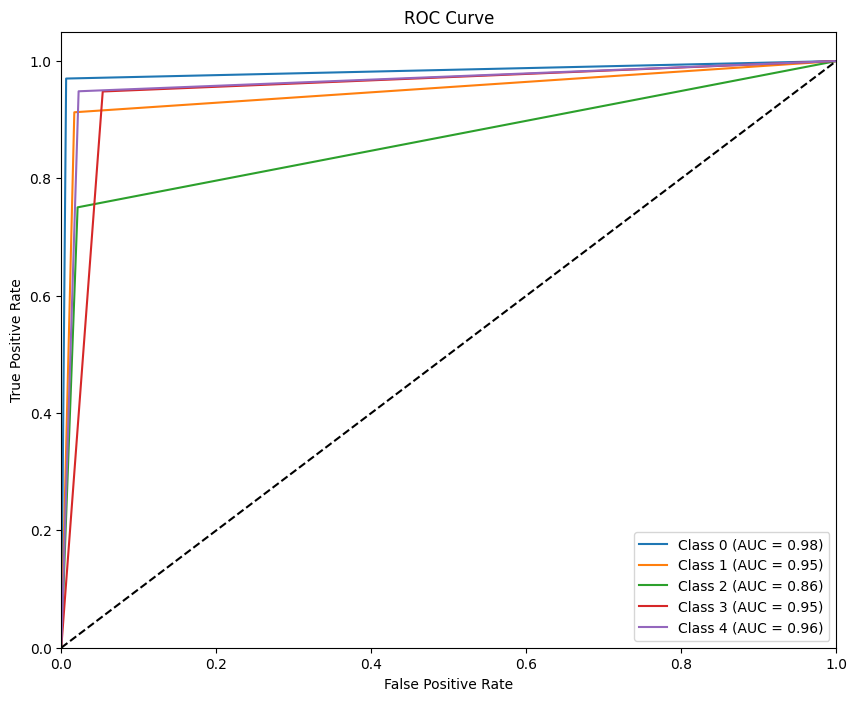

In [36]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 5  # Assuming there are 5 classes
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_val_up_resnet50 == i, y_test_renset50 == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# **2. Xception**

In [37]:
from tensorflow.keras.applications import Xception

In [38]:
# Create and compile Xception model with the correct learning rate argument
xception_base = create_base_model(Xception)
xception_upsampled_model = add_top_model(xception_base)
xception_upsampled_model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Ensure y_train_up and y_val_up are one-hot encoded
xception_model = xception_upsampled_model.fit(x_train_up, y_train_up, epochs=30, batch_size=32, validation_data=(x_val_up, y_val_up))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.5844 - loss: 4.8217 - val_accuracy: 0.9806 - val_loss: 0.6969
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.7425 - loss: 0.9975 - val_accuracy: 0.8676 - val_loss: 0.3890
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - accuracy: 0.7228 - loss: 0.5060 - val_accuracy: 0.8183 - val_loss: 0.3668
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.7458 - loss: 0.4440 - val_accuracy: 0.8853 - val_loss: 0.3479
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.7503 - loss: 0.4208 - val_accuracy: 0.9385 - val_loss: 0.3361
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8018 - loss: 0.4044 - val_accuracy: 0.9490 - val_loss: 0.3245
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8179 - loss: 0.3837 - val_accuracy: 0.9274 - val_loss: 0.3154
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━

In [183]:
# Calculate and print accuracy for training, validation, and test sets
train_accuracy_xception = xception_upsampled_model.evaluate(x_train_up, y_train_up)[1]
val_accuracy_xception = xception_upsampled_model.evaluate(x_val_up, y_val_up)[1]
# Calculate and print loss for training and validation sets
train_loss_xception, train_accuracy_xception = xception_upsampled_model.evaluate(x_train_up, y_train_up)
val_loss_xception, val_accuracy_xception = xception_upsampled_model.evaluate(x_val_up, y_val_up)

print("Xception Model Accuracy:")
print(f"Training Accuracy: {train_accuracy_xception}")
print(f"Validation Accuracy: {val_accuracy_xception}")

print("Xception Model Loss:")
print(f"Training Loss: {train_loss_xception}")
print(f"Validation Loss: {val_loss_xception}")


226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9930 - loss: 0.2212
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9960 - loss: 0.2235
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.9930 - loss: 0.2212
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9960 - loss: 0.2235
Xception Model Accuracy:
Training Accuracy: 0.9936287999153137
Validation Accuracy: 0.9950138330459595
Xception Model Loss:
Training Loss: 0.2227703183889389
Validation Loss: 0.23374323546886444


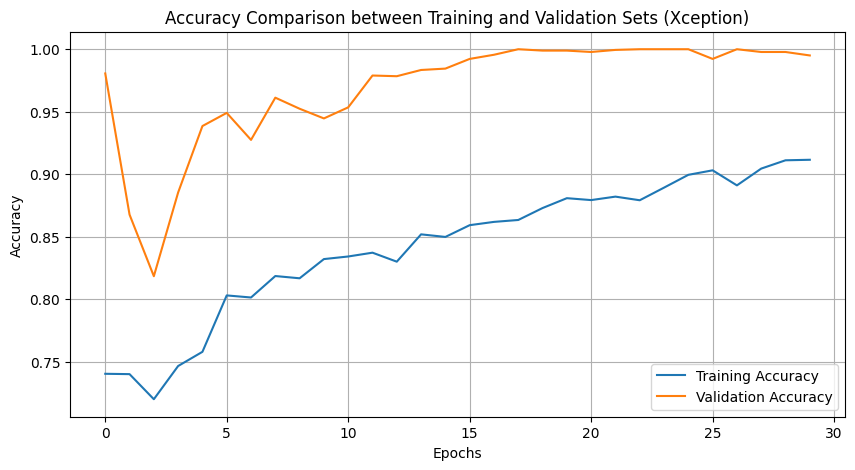

In [52]:
# Plotting Accuracy for Xception
plt.figure(figsize=(10, 5))
plt.plot(xception_model.history['accuracy'], label='Training Accuracy')
plt.plot(xception_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Comparison between Training and Validation Sets (Xception)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

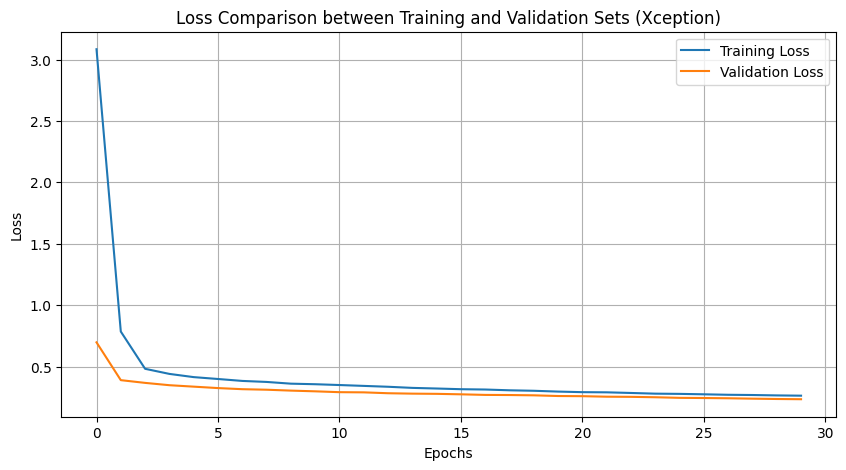

In [51]:
# Plotting Loss for ResNet50
plt.figure(figsize=(10, 5))
plt.plot(xception_model.history['loss'], label='Training Loss')
plt.plot(xception_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Comparison between Training and Validation Sets (Xception)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_val_pred_xception = xception_upsampled_model.predict(x_val_up)

y_best_xception = y_val_pred_xception > 0.37757874193797547


y_best_xception  = y_best_xception .astype(int).sum(axis=1) - 1

y_true = y_val_up.sum(axis=1) - 1



print('Confusion Matrix')
print(confusion_matrix(y_best_xception, y_true))


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step
Confusion Matrix
[[292  11   9   0   3]
 [ 47 140  18   3   4]
 [ 20 132 162   9  44]
 [  9  78 166 320 122]
 [  1  17  26  15 157]]


In [43]:
from sklearn.metrics import classification_report, precision_score, recall_score 
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best_xception, y_true, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       No DR       0.79      0.93      0.85       315
        Mild       0.37      0.66      0.47       212
    Moderate       0.43      0.44      0.43       367
      Severe       0.92      0.46      0.61       695
Poliferative       0.48      0.73      0.58       216

    accuracy                           0.59      1805
   macro avg       0.60      0.64      0.59      1805
weighted avg       0.68      0.59      0.60      1805



In [44]:

cm = confusion_matrix(y_best_xception, y_true)

sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

precision = precision_score(y_best_xception, y_true, average=None)

recall = recall_score(y_best_xception, y_true, average=None)


print("Sensitivity (True Positive Rate or Recall):", sensitivity)
print("\nSpecificity:", specificity)
print("\nPrecision for each class:",precision)
print("\nRecall for each class:", recall)


Sensitivity (True Positive Rate or Recall): 0.7486631016042781

Specificity: 0.9636963696369637

Precision for each class: [0.79132791 0.37037037 0.42519685 0.9221902  0.47575758]

Recall for each class: [0.92698413 0.66037736 0.44141689 0.46043165 0.72685185]


In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(y_true, y_best_xception, average='micro')

recall = recall_score(y_true, y_best_xception, average='micro')

print("\nPrecision for each class:")
print(precision)
print("\nRecall for each class:")
print(recall)


Precision for each class:
0.5933518005540166

Recall for each class:
0.5933518005540166


In [46]:
misclassified=np.where(y_best_xception!=y_true)
misclassified

print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_true[15],y_best_xception[15])


Total Misclassified Samples:  734
3 3


In [47]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa score
kappa_score = cohen_kappa_score(y_true, y_best_xception)

# Print the Kappa score
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.49226675128440367


In [48]:
y_test_xception = xception_upsampled_model.predict(x_val_up)
y_test_xception
y_test_xception = y_test_xception > 0.37757874193797547
y_test_xception
y_test_xception = y_test_xception.astype(int).sum(axis=1) - 1
y_test_xception

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


array([3, 3, 0, ..., 3, 2, 3])

In [49]:
y_val_up_xception = y_val_up.astype(int).sum(axis=1) - 1
y_val_up_xception

array([1, 3, 0, ..., 4, 3, 2])

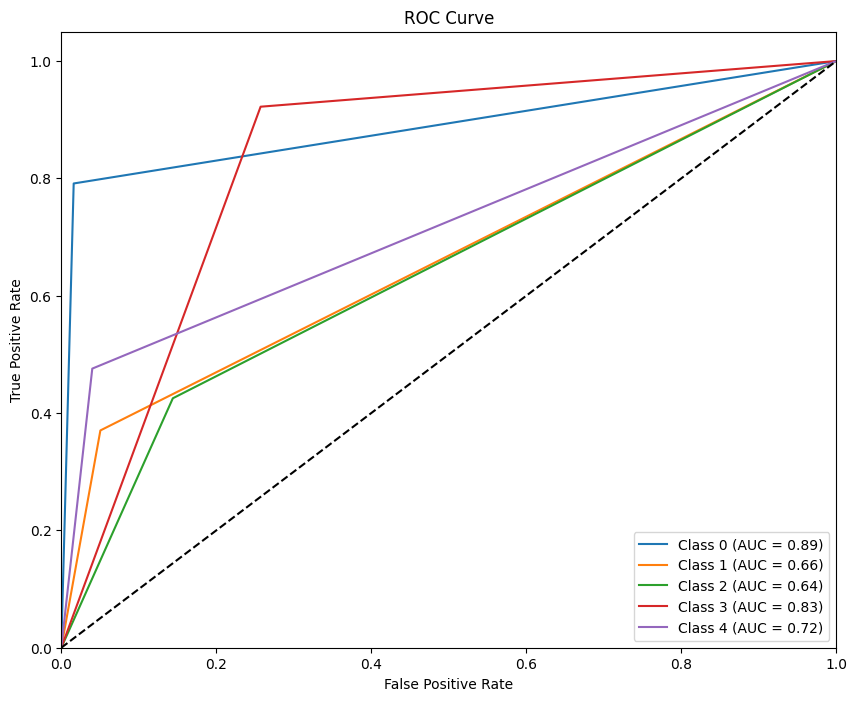

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 5  # Assuming there are 5 classes
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_val_up_xception == i, y_test_xception == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **3. InceptionV3**

In [53]:
from tensorflow.keras.applications import InceptionV3

In [55]:
inceptionv3_base = create_base_model(InceptionV3)
inceptionv3_upsampled_model = add_top_model(inceptionv3_base)
inceptionv3_upsampled_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Ensure y_train_up and y_val_up are one-hot encoded
inceptionv3_model = inceptionv3_upsampled_model.fit(x_train_up, y_train_up, epochs=30, batch_size=32, validation_data=(x_val_up, y_val_up))

Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.5309 - loss: 3.2668 - val_accuracy: 0.9917 - val_loss: 0.8429
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7705 - loss: 1.8003 - val_accuracy: 0.9512 - val_loss: 0.5875
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7684 - loss: 1.0053 - val_accuracy: 0.9053 - val_loss: 0.4580
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.7547 - loss: 0.6777 - val_accuracy: 0.8620 - val_loss: 0.4137
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7598 - loss: 0.5611 - val_accuracy: 0.8609 - val_loss: 0.3985
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7676 - loss: 0.5182 - val_accuracy: 0.8537 - val_loss: 0.3907
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7463 - loss: 0.4917 - val_accuracy: 0.8709 - val_loss: 0.3811
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7606 - loss: 0.4709 -

In [184]:
# Calculate and print accuracy for training, validation, and test sets
train_accuracy_inceptionv3 = inceptionv3_upsampled_model.evaluate(x_train_up, y_train_up)[1]
val_accuracy_inceptionv3 = inceptionv3_upsampled_model.evaluate(x_val_up, y_val_up)[1]
# Calculate and print loss for training and validation sets
train_loss_inceptionv3, train_accuracy_inceptionv3 = inceptionv3_upsampled_model.evaluate(x_train_up, y_train_up)
val_loss_inceptionv3, val_accuracy_inceptionv3 = inceptionv3_upsampled_model.evaluate(x_val_up, y_val_up)


print("InceptionV3 Model Accuracy:")
print(f"Training Accuracy: {train_accuracy_inceptionv3}")
print(f"Validation Accuracy: {val_accuracy_inceptionv3}")

print("InceptionV3 Model Loss:")
print(f"Training Loss: {train_loss_inceptionv3}")
print(f"Validation Loss: {val_loss_inceptionv3}")


226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9839 - loss: 0.2941
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9850 - loss: 0.2975
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9839 - loss: 0.2941
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9850 - loss: 0.2975
InceptionV3 Model Accuracy:
Training Accuracy: 0.9824099540710449
Validation Accuracy: 0.9828254580497742
InceptionV3 Model Loss:
Training Loss: 0.2944684624671936
Validation Loss: 0.29644259810447693


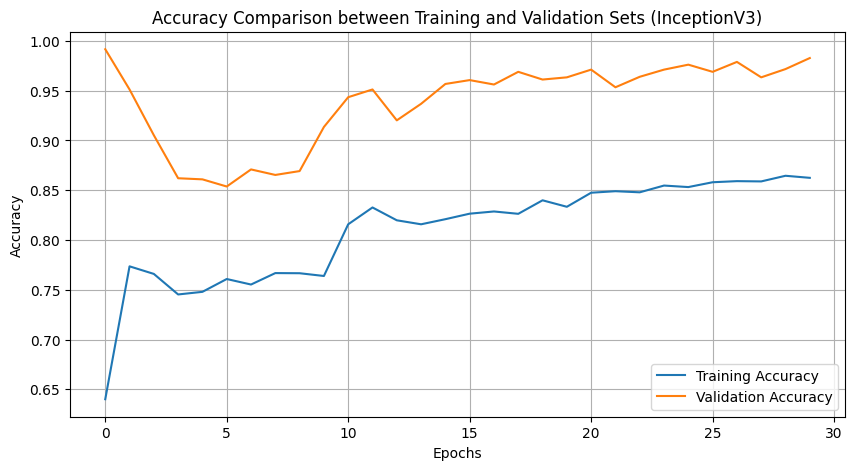

In [57]:
# Plotting Accuracy for InceptionV3
plt.figure(figsize=(10, 5))
plt.plot(inceptionv3_model.history['accuracy'], label='Training Accuracy')
plt.plot(inceptionv3_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Comparison between Training and Validation Sets (InceptionV3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


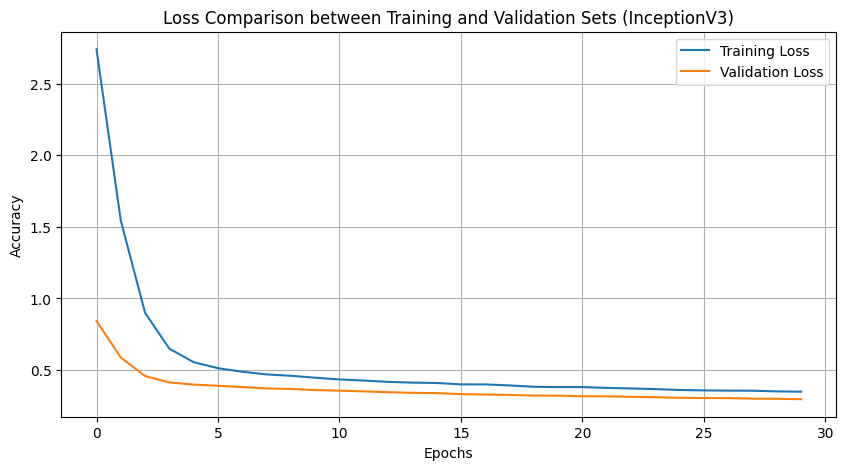

In [58]:
# Plotting Loss for InceptionV3
plt.figure(figsize=(10, 5))
plt.plot(inceptionv3_model.history['loss'], label='Training Loss')
plt.plot(inceptionv3_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Comparison between Training and Validation Sets (InceptionV3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_val_pred_inceptionv3 = inceptionv3_upsampled_model.predict(x_val_up)

y_best_inceptionv3 = y_val_pred_inceptionv3 > 0.37757874193797547


y_best_inceptionv3  = y_best_inceptionv3 .astype(int).sum(axis=1) - 1

y_true = y_val_up.sum(axis=1) - 1


print('Confusion Matrix')
print(confusion_matrix(y_best_inceptionv3, y_true))


57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step
Confusion Matrix
[[250  21  12   0   1]
 [ 59  79  19   3   7]
 [ 44 161 159  43  98]
 [ 14 110 182 294 167]
 [  2   7   9   7  57]]


In [60]:
from sklearn.metrics import classification_report, precision_score, recall_score 
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best_inceptionv3, y_true, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

       No DR       0.68      0.88      0.77       284
        Mild       0.21      0.47      0.29       167
    Moderate       0.42      0.31      0.36       505
      Severe       0.85      0.38      0.53       767
Poliferative       0.17      0.70      0.28        82

    accuracy                           0.46      1805
   macro avg       0.46      0.55      0.44      1805
weighted avg       0.61      0.46      0.48      1805



In [61]:
cm = confusion_matrix(y_best_inceptionv3, y_true)

sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

precision = precision_score(y_true, y_best_inceptionv3, average=None)

recall = recall_score(y_true, y_best_inceptionv3, average=None)


print("Sensitivity (True Positive Rate or Recall):", sensitivity)
print("\nSpecificity:", specificity)
print("\nPrecision for each class:",precision)
print("\nRecall for each class:", recall)


Sensitivity (True Positive Rate or Recall): 0.572463768115942

Specificity: 0.922509225092251

Precision for each class: [0.88028169 0.47305389 0.31485149 0.3833116  0.69512195]

Recall for each class: [0.67750678 0.20899471 0.41732283 0.84726225 0.17272727]


In [62]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(y_true, y_best_inceptionv3, average='micro')

recall = recall_score(y_true, y_best_inceptionv3, average='micro')

print("\nPrecision for each class:")
print(precision)
print("\nRecall for each class:")
print(recall)



Precision for each class:
0.464819944598338

Recall for each class:
0.464819944598338


In [63]:
misclassified=np.where(y_best_inceptionv3!=y_true)
misclassified

print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_true[15],y_best_inceptionv3[15])


Total Misclassified Samples:  966
3 2


In [64]:

from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa score
kappa_score = cohen_kappa_score(y_true, y_best_inceptionv3)

# Print the Kappa score
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.33052894444937186


In [65]:
y_test_inceptionv3 = inceptionv3_upsampled_model.predict(x_val_up)
y_test_inceptionv3
y_test_inceptionv3 = y_test_inceptionv3 > 0.37757874193797547
y_test_inceptionv3
y_test_inceptionv3 = y_test_inceptionv3.astype(int).sum(axis=1) - 1
y_test_inceptionv3

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


array([1, 3, 0, ..., 3, 2, 3])

In [66]:
y_val_up_inceptionv3 = y_val_up.astype(int).sum(axis=1) - 1
y_val_up_inceptionv3

array([1, 3, 0, ..., 4, 3, 2])

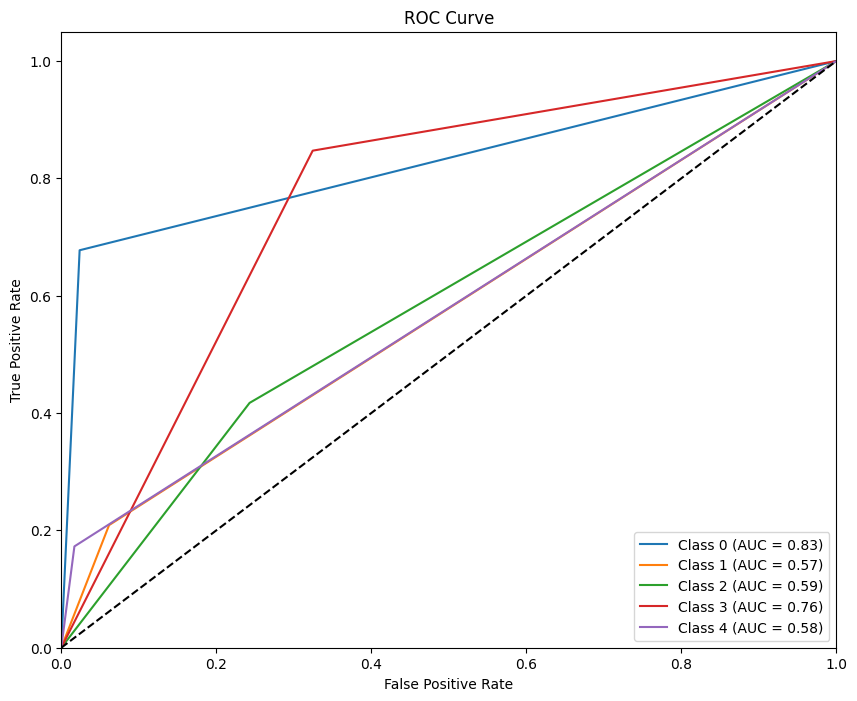

In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 5  # Assuming there are 5 classes
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_val_up_inceptionv3 == i, y_test_inceptionv3 == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# **4. DenseNet121**

In [69]:
from tensorflow.keras.applications import DenseNet121

In [71]:
densenet121_base = create_base_model(DenseNet121)
densenet121_upsampled_model = add_top_model(densenet121_base)
densenet121_upsampled_model.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

# Ensure y_train_up and y_val_up are one-hot encoded
densenet121_model = densenet121_upsampled_model.fit(x_train_up, y_train_up, epochs=30, batch_size=32, validation_data=(x_val_up, y_val_up))

Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 54s 151ms/step - accuracy: 0.6239 - loss: 2.4123 - val_accuracy: 0.9856 - val_loss: 1.3681
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6579 - loss: 2.0390 - val_accuracy: 0.9873 - val_loss: 1.0225
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6654 - loss: 1.8087 - val_accuracy: 0.9906 - val_loss: 0.7749
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.6756 - loss: 1.5637 - val_accuracy: 0.9934 - val_loss: 0.6525
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.6845 - loss: 1.4159 - val_accuracy: 0.9939 - val_loss: 0.6136
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7038 - loss: 1.3852 - val_accuracy: 0.9922 - val_loss: 0.6087
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7092 - loss: 1.3294 - val_accuracy: 0.9900 - val_loss: 0.6130
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.7030 - loss: 1.2663 -

In [185]:
# Calculate and print accuracy for training, validation, and test sets
train_accuracy_densenet121 = densenet121_upsampled_model.evaluate(x_train_up, y_train_up)[1]
val_accuracy_densenet121 = densenet121_upsampled_model.evaluate(x_val_up, y_val_up)[1]
# Calculate and print loss for training and validation sets
train_loss_densenet121, train_accuracy_densenet121 = densenet121_upsampled_model.evaluate(x_train_up, y_train_up)
val_loss_densenet121, val_accuracy_densenet121 = densenet121_upsampled_model.evaluate(x_val_up, y_val_up)

print("DenseNet121 Model Accuracy:")
print(f"Training Accuracy: {train_accuracy_densenet121}")
print(f"Validation Accuracy: {val_accuracy_densenet121}")


print("DenseNet121 Model Loss:")
print(f"Training Loss: {train_loss_densenet121}")
print(f"Validation Loss: {val_loss_densenet121}")

226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.9936 - loss: 0.4480
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.9888 - loss: 0.4498
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9936 - loss: 0.4480
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9888 - loss: 0.4498
DenseNet121 Model Accuracy:
Training Accuracy: 0.9927977919578552
Validation Accuracy: 0.9900277256965637
DenseNet121 Model Loss:
Training Loss: 0.45311829447746277
Validation Loss: 0.4496465027332306


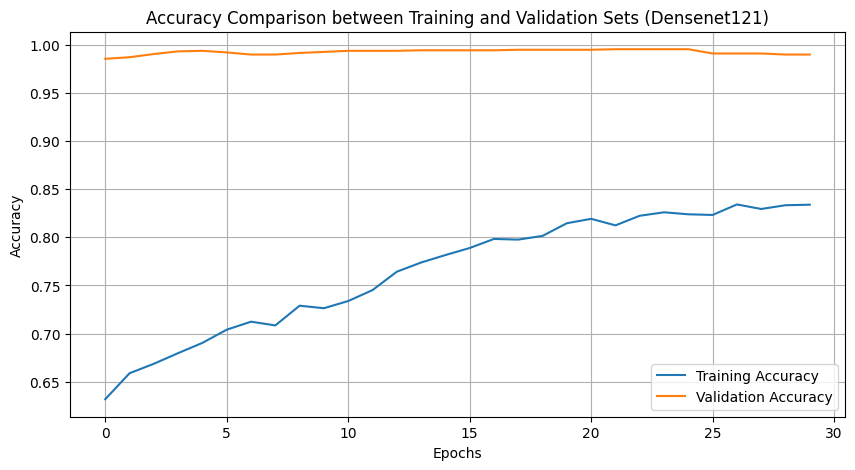

In [73]:
# Plotting Accuracy for Densenet121
plt.figure(figsize=(10, 5))
plt.plot(densenet121_model.history['accuracy'], label='Training Accuracy')
plt.plot(densenet121_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Comparison between Training and Validation Sets (Densenet121)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

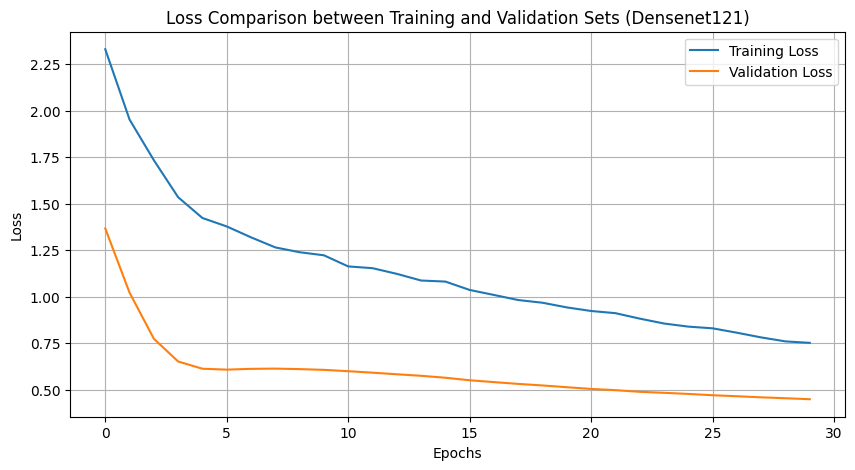

In [74]:
# Plotting Loss for DenseNet121
plt.figure(figsize=(10, 5))
plt.plot(densenet121_model.history['loss'], label='Training Loss')
plt.plot(densenet121_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Comparison between Training and Validation Sets (Densenet121)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_val_pred_densenet121 = densenet121_upsampled_model.predict(x_val_up)

y_best_densenet121 = y_val_pred_densenet121 > 0.37757874193797547


y_best_densenet121  = y_best_densenet121 .astype(int).sum(axis=1) - 1

y_true = y_val_up.sum(axis=1) - 1



print('Confusion Matrix')
print(confusion_matrix(y_best_densenet121, y_true))


57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step
Confusion Matrix
[[104  15  12   3  13]
 [103  28  12  13  12]
 [ 59 202 166 117 150]
 [102 133 191 214 155]
 [  1   0   0   0   0]]


In [76]:
from sklearn.metrics import classification_report, precision_score, recall_score 
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best_densenet121, y_true, target_names=target_names))


cm = confusion_matrix(y_best_densenet121, y_true)

sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

precision = precision_score(y_true, y_best_densenet121, average=None)

recall = recall_score(y_true, y_best_densenet121, average=None)


print("Sensitivity (True Positive Rate or Recall):", sensitivity)
print("\nSpecificity:", specificity)
print("\nPrecision for each class:",precision)
print("\nRecall for each class:", recall)


Classification Report
              precision    recall  f1-score   support

       No DR       0.28      0.71      0.40       147
        Mild       0.07      0.17      0.10       168
    Moderate       0.44      0.24      0.31       694
      Severe       0.62      0.27      0.37       795
Poliferative       0.00      0.00      0.00         1

    accuracy                           0.28      1805
   macro avg       0.28      0.28      0.24      1805
weighted avg       0.47      0.28      0.33      1805

Sensitivity (True Positive Rate or Recall): 0.21374045801526717

Specificity: 0.8739495798319328

Precision for each class: [0.70748299 0.16666667 0.23919308 0.26918239 0.        ]

Recall for each class: [0.28184282 0.07407407 0.43569554 0.6167147  0.        ]


In [77]:
misclassified=np.where(y_best_densenet121!=y_true)
misclassified

print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_true[15],y_best_densenet121[15])


Total Misclassified Samples:  1293
3 3


In [78]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa score
kappa_score = cohen_kappa_score(y_true, y_best_densenet121)

# Print the Kappa score
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.10224532430859457


In [79]:
y_test_densenet121 = densenet121_upsampled_model.predict(x_val_up)
y_test_densenet121
y_test_densenet121 = y_test_densenet121 > 0.37757874193797547
y_test_densenet121
y_test_densenet121 = y_test_densenet121.astype(int).sum(axis=1) - 1
y_test_densenet121


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


array([3, 3, 1, ..., 3, 3, 3])

In [80]:
y_val_up_densenet121 = y_val_up.astype(int).sum(axis=1) - 1
y_val_up_densenet121

array([1, 3, 0, ..., 4, 3, 2])

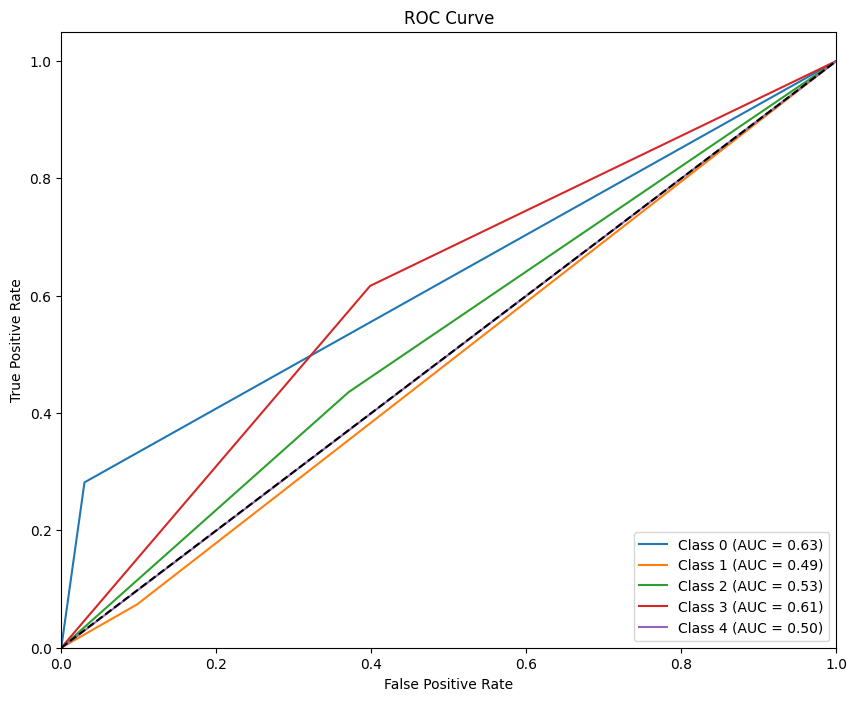

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 5  # Assuming there are 5 classes
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_val_up_densenet121 == i, y_test_densenet121 == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



# **5. Densenet169**

In [82]:
from tensorflow.keras.applications import DenseNet169

In [89]:
densenet169_base = create_base_model(DenseNet169)
densenet169_upsampled_model = add_top_model(densenet169_base)
densenet169_upsampled_model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

# Ensure y_train_up and y_val_up are one-hot encoded
densenet169_model = densenet169_upsampled_model.fit(x_train_up, y_train_up, epochs=30, batch_size=32, validation_data=(x_val_up, y_val_up))

Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 75s 206ms/step - accuracy: 0.6221 - loss: 0.9353 - val_accuracy: 0.9424 - val_loss: 0.3596
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8078 - loss: 0.4283 - val_accuracy: 0.9114 - val_loss: 0.3328
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7937 - loss: 0.3728 - val_accuracy: 0.8332 - val_loss: 0.3163
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7806 - loss: 0.3600 - val_accuracy: 0.9158 - val_loss: 0.3030
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7909 - loss: 0.3380 - val_accuracy: 0.9396 - val_loss: 0.2961
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7943 - loss: 0.3272 - val_accuracy: 0.8870 - val_loss: 0.2851
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8155 - loss: 0.3144 - val_accuracy: 0.9186 - val_loss: 0.2795
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.8210 - loss: 0.3101 -

In [186]:

# Calculate and print accuracy for training, validation, and test sets
train_accuracy_densenet169 = densenet169_upsampled_model.evaluate(x_train_up, y_train_up)[1]
val_accuracy_densenet169 = densenet169_upsampled_model.evaluate(x_val_up, y_val_up)[1]
# Calculate and print loss for training and validation sets
train_loss_densenet169, train_accuracy_densenet169 = densenet169_upsampled_model.evaluate(x_train_up, y_train_up)
val_loss_densenet169, val_accuracy_densenet169 = densenet169_upsampled_model.evaluate(x_val_up, y_val_up)


print("DenseNet169 Model Accuracy:")
print(f"Training Accuracy: {train_accuracy_densenet169}")
print(f"Validation Accuracy: {val_accuracy_densenet169}")

print("DenseNet169 Model Loss:")
print(f"Training Loss: {train_loss_densenet169}")
print(f"Validation Loss: {val_loss_densenet169}")


226/226 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.9986 - loss: 0.1876
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.9980 - loss: 0.1969
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.9986 - loss: 0.1876
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9980 - loss: 0.1969
DenseNet169 Model Accuracy:
Training Accuracy: 0.9990304708480835
Validation Accuracy: 0.9994459748268127
DenseNet169 Model Loss:
Training Loss: 0.18903493881225586
Validation Loss: 0.20132775604724884


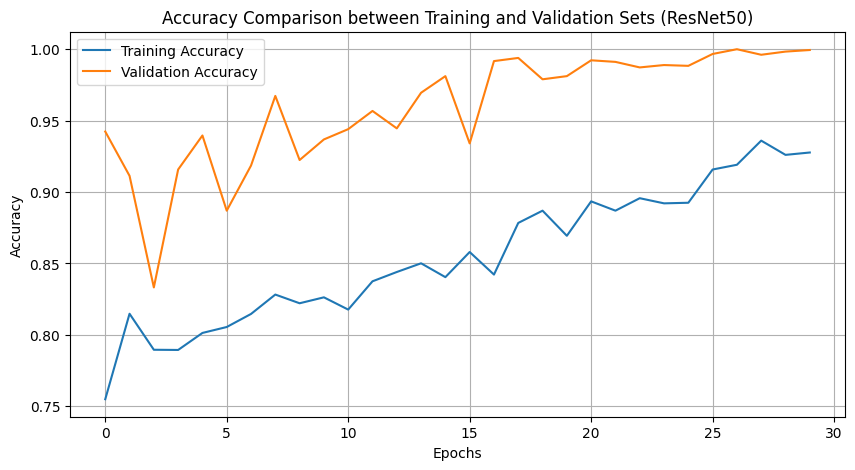

In [91]:

# Plotting Accuracy for DenseNet169
plt.figure(figsize=(10, 5))
plt.plot(densenet169_model.history['accuracy'], label='Training Accuracy')
plt.plot(densenet169_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Comparison between Training and Validation Sets (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


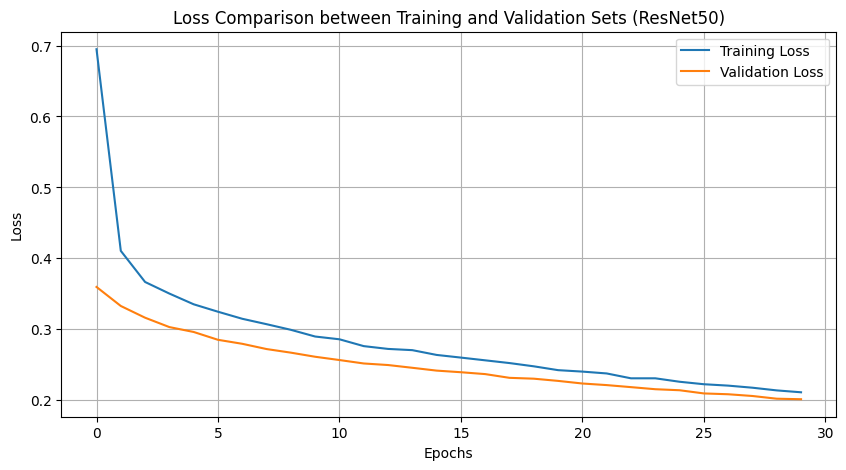

In [92]:
# Plotting Loss for ResNet50
plt.figure(figsize=(10, 5))
plt.plot(densenet169_model.history['loss'], label='Training Loss')
plt.plot(densenet169_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Comparison between Training and Validation Sets (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_val_pred_densenet169 = densenet169_upsampled_model.predict(x_val_up)

y_best_densenet169 = y_val_pred_densenet169 > 0.37757874193797547


y_best_densenet169  = y_best_densenet169 .astype(int).sum(axis=1) - 1

y_true = y_val_up.sum(axis=1) - 1



print('Confusion Matrix')
print(confusion_matrix(y_best_densenet169, y_true))


57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 262ms/step
Confusion Matrix
[[338  19   5   0   2]
 [ 21 177  39   0   9]
 [  9 142 196  30  56]
 [  1  37 123 302  92]
 [  0   3  18  15 171]]


In [94]:

from sklearn.metrics import classification_report, precision_score, recall_score 
print('Classification Report')
target_names = ['No DR', 'Mild', 'Moderate','Severe','Poliferative']
print(classification_report(y_best_densenet169, y_true, target_names=target_names))




Classification Report
              precision    recall  f1-score   support

       No DR       0.92      0.93      0.92       364
        Mild       0.47      0.72      0.57       246
    Moderate       0.51      0.45      0.48       433
      Severe       0.87      0.54      0.67       555
Poliferative       0.52      0.83      0.64       207

    accuracy                           0.66      1805
   macro avg       0.66      0.69      0.66      1805
weighted avg       0.70      0.66      0.66      1805



In [95]:

cm = confusion_matrix(y_best_densenet169, y_true)

sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])

specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

precision = precision_score(y_true ,y_best_densenet169,average=None)

recall = recall_score(y_true,y_best_densenet169,average=None)


print("Sensitivity (True Positive Rate or Recall):", sensitivity)
print("\nSpecificity:", specificity)
print("\nPrecision for each class:",precision)
print("\nRecall for each class:", recall)


Sensitivity (True Positive Rate or Recall): 0.8939393939393939

Specificity: 0.9467787114845938

Precision for each class: [0.92857143 0.7195122  0.45265589 0.54414414 0.82608696]

Recall for each class: [0.91598916 0.46825397 0.5144357  0.870317   0.51818182]


In [96]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
precision = precision_score(y_true, y_best_densenet169,average='micro')

recall = recall_score(y_true,y_best_densenet169,average='micro')

print("\nPrecision for each class:")
print(precision)
print("\nRecall for each class:")
print(recall)



Precision for each class:
0.6559556786703601

Recall for each class:
0.6559556786703601


In [97]:
misclassified=np.where(y_best_densenet169!=y_true)
misclassified

print("Total Misclassified Samples: ",len(misclassified[0]))
print(y_true[15],y_best_densenet169[15])

Total Misclassified Samples:  621
3 3


In [98]:

from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa score
kappa_score = cohen_kappa_score(y_true, y_best_densenet169)

# Print the Kappa score
print("Cohen's Kappa Score:", kappa_score)

Cohen's Kappa Score: 0.5696858901442807


In [99]:
y_test_densenet169 = densenet169_upsampled_model.predict(x_val_up)
y_test_densenet169
y_test_densenet169 = y_test_densenet169 > 0.37757874193797547
y_test_densenet169
y_test_densenet169 = y_test_densenet169.astype(int).sum(axis=1) - 1
y_test_densenet169

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


array([3, 3, 0, ..., 3, 2, 3])

In [100]:
y_val_up_densenet169 = y_val_up.astype(int).sum(axis=1) - 1
y_val_up_densenet169

array([1, 3, 0, ..., 4, 3, 2])

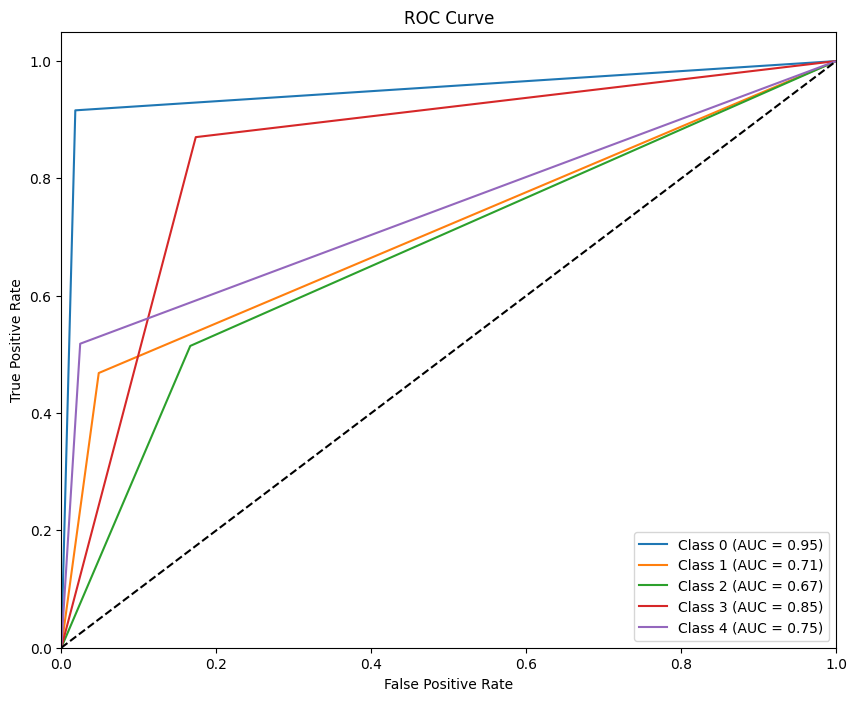

In [101]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 5  # Assuming there are 5 classes
for i in range(num_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_val_up_densenet169 == i, y_test_densenet169 == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



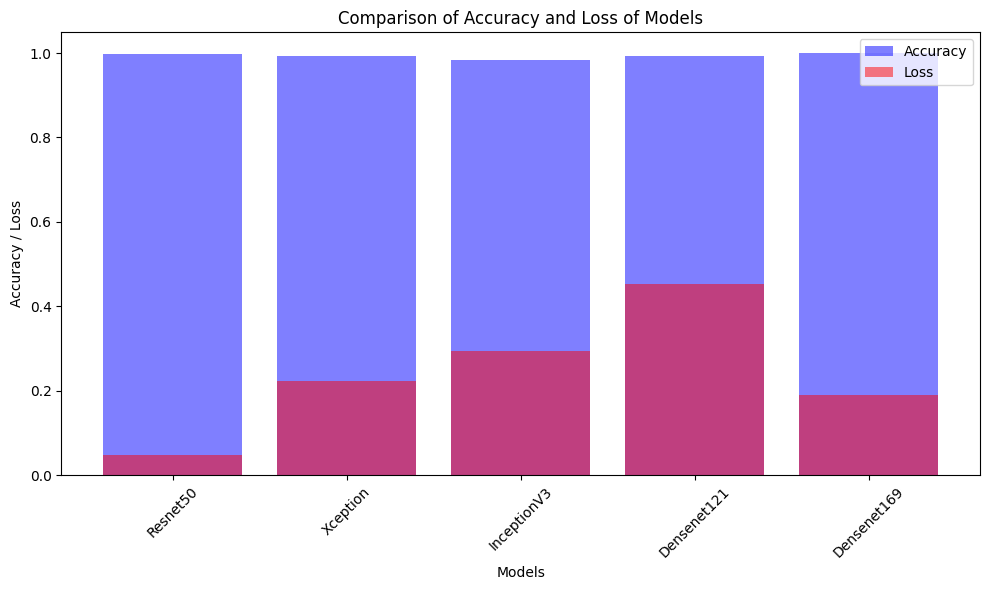

In [188]:
import matplotlib.pyplot as plt

# Assuming you have calculated accuracy and loss for each model and stored them in lists
models = ['Resnet50','Xception','InceptionV3','Densenet121','Densenet169']
accuracy = [train_accuracy_renset50, train_accuracy_xception, train_accuracy_inceptionv3, train_accuracy_densenet121, train_accuracy_densenet169]
loss = [train_loss_resnet50, train_loss_xception, train_loss_inceptionv3, train_loss_densenet121, train_loss_densenet169]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting accuracy
ax.bar(models, accuracy, color='blue', alpha=0.5, label='Accuracy')

# Plotting loss
ax.bar(models, loss, color='red', alpha=0.5, label='Loss')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy / Loss')
ax.set_title('Comparison of Accuracy and Loss of Models')
ax.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


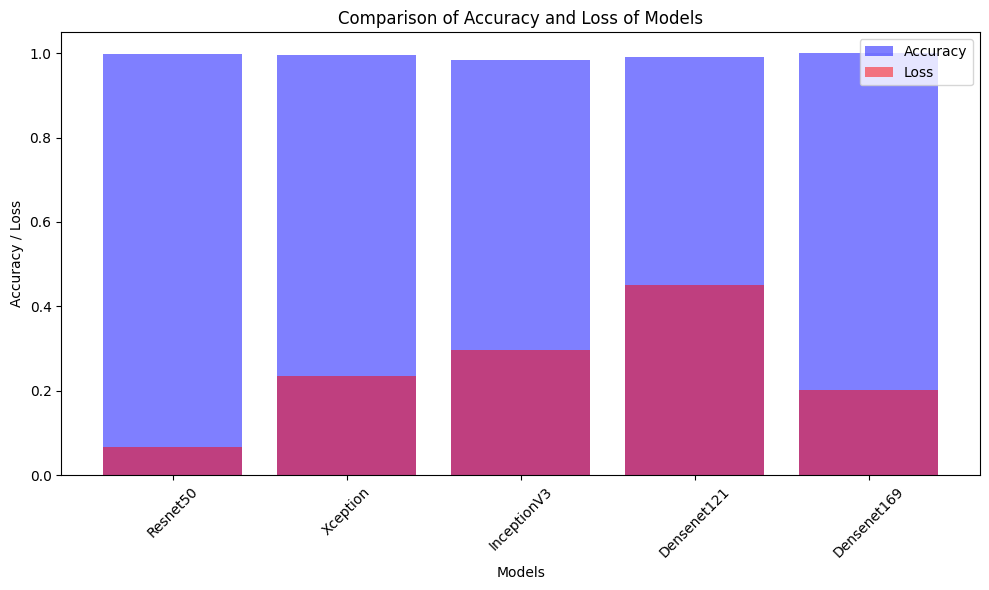

In [192]:
import matplotlib.pyplot as plt

# Assuming you have calculated accuracy and loss for each model and stored them in lists
models = ['Resnet50','Xception','InceptionV3','Densenet121','Densenet169']
accuracy = [val_accuracy_resnet50, val_accuracy_xception, val_accuracy_inceptionv3, val_accuracy_densenet121, val_accuracy_densenet169]
loss = [val_loss_resnet50, val_loss_xception, val_loss_inceptionv3, val_loss_densenet121, val_loss_densenet169]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting accuracy
ax.bar(models, accuracy, color='blue', alpha=0.5, label='Accuracy')

# Plotting loss
ax.bar(models, loss, color='red', alpha=0.5, label='Loss')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy / Loss')
ax.set_title('Comparison of Accuracy and Loss of Models')
ax.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


**Saving Models**

In [172]:
resnet50_upsampled_model.save('resnet50.h5')
inceptionv3_upsampled_model.save('inceptionv3.h5')
xception_upsampled_model.save('xception.h5')
densenet121_upsampled_model.save('densenet121.h5') 
densenet169_upsampled_model.save('densenet169.h5')

# **Ensemble**

In [208]:
# Function to make predictions using an ensemble of models
def ensemble_predict(models, x_test):
  ensemble_predictions = np.zeros((x_test.shape[0], 5))
  for model in models:
    ensemble_predictions += model.predict(x_test) / len(models)  # Average predictions
  return ensemble_predictions

In [211]:
# Make predictions on validation data using the ensemble
# Make predictions on validation data using the ensemble
val_predictions = ensemble_predict([resnet50_upsampled_model, inceptionv3_upsampled_model, xception_upsampled_model, densenet121_upsampled_model, densenet169_upsampled_model], x_val_up)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


In [213]:
# Evaluate the ensemble model (calculate accuracy, etc.)
accuracy = accuracy_score(y_val_up, np.round(val_predictions))
print("Ensemble Model Validation Accuracy:", accuracy)

Ensemble Model Validation Accuracy: 0.7135734072022161


In [216]:
# Make predictions on validation data using the ensemble
train_predictions = ensemble_predict([resnet50_upsampled_model, inceptionv3_upsampled_model, xception_upsampled_model, densenet121_upsampled_model, densenet169_upsampled_model], x_train_up)


226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step


In [217]:
# Evaluate the ensemble model (calculate accuracy, etc.)
accuracy = accuracy_score(y_train_up, np.round(train_predictions))
print("Ensemble Model Validation Accuracy:", accuracy)

Ensemble Model Validation Accuracy: 0.725207756232687


In [218]:
y_val_pred_resnet50 = resnet50_upsampled_model.predict(x_val_up)
y_val_pred_xception = xception_upsampled_model.predict(x_val_up)
y_val_pred_inceptionv3 = inceptionv3_upsampled_model.predict(x_val_up)
y_val_pred_densenet121 = densenet121_upsampled_model.predict(x_val_up)
y_val_pred_densenet169 = densenet169_upsampled_model.predict(x_val_up)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


In [237]:
ensemble_pred = (y_val_pred_resnet50 + y_val_pred_xception + y_val_pred_inceptionv3 + y_val_pred_densenet121 + y_val_pred_densenet169) / 5

In [238]:
y_ensemble_pred = ensemble_pred > 0.37757874193797547


In [239]:
y_ensemb1 = y_ensemble_pred.astype(int).sum(axis=1)-1

In [240]:
y_actual = y_val_up.sum(axis=1) - 1
y_actual

array([1, 3, 0, ..., 4, 3, 2])

In [241]:
print("Shape of y_actual:", y_actual.shape)
print("Shape of y_ensemble_pred:", y_ensemb.shape)
print("Type of y_actual:", type(y_actual))
print("Type of y_ensemble_pred:", type(y_ensemb))


Shape of y_actual: (1805,)
Shape of y_ensemble_pred: (1805,)
Type of y_actual: <class 'numpy.ndarray'>
Type of y_ensemble_pred: <class 'numpy.ndarray'>


In [243]:
accuracy_ensemble = accuracy_score(y_actual, y_ensemb1)
confusion_matrix_ensemble = confusion_matrix(y_actual, y_ensemb1)
classification_report_ensemble = classification_report(y_actual, y_ensemb1)

print("Ensemble Model Accuracy:", accuracy_ensemble)
print("Confusion Matrix:")
print(confusion_matrix_ensemble)
print("Classification Report:")
print(classification_report_ensemble)

Ensemble Model Accuracy: 0.6759002770083102
Confusion Matrix:
[[310  37  20   2   0]
 [  7 129 217  25   0]
 [  4  13 240 123   1]
 [  0   0   5 339   3]
 [  0   2  12 114 202]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       369
           1       0.71      0.34      0.46       378
           2       0.49      0.63      0.55       381
           3       0.56      0.98      0.71       347
           4       0.98      0.61      0.75       330

    accuracy                           0.68      1805
   macro avg       0.74      0.68      0.68      1805
weighted avg       0.74      0.68      0.67      1805

